In [1]:
cd ..

/home/max/Documents/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd

from src.generate import load_dataset
from src.reasoner import *
from src.utils import *

train_onto, test_onto, data_tr, data_vl, data_te = load_dataset('local/out/dataset/sub-100.json')
test_df = pd.read_csv('local/out/exp/20220715T194304/test-results.csv')

In [3]:
def new_stats():
    return dict(con=set(), rol=set(), n_bot=0, n_not=0, n_and=0, n_any=0, n_con=0, n_rol=0, depth=0)

def merge_stats(lhs, rhs):
    for key in ['n_bot', 'n_not', 'n_and', 'n_any']:
        lhs[key] += rhs[key]
    for key in ['con', 'rol', 'n_any']:
        lhs[key] |= rhs[key]
    lhs['depth'] = max(lhs['depth'], rhs['depth'])
    return lhs

def expr_stats(expr_):
    def stats(expr):
        if expr == BOT:
            result = new_stats()
            result['n_bot'] += 1
            return result
        elif isinstance(expr, int):
            result = new_stats()
            result['con'].add(expr)
            return result
        elif expr[0] == NOT:
            result = stats(expr[1])
            result['n_not'] += 1
            result['depth'] += 1
            return result
        elif expr[0] == AND:
            lhs = stats(expr[1])
            rhs = stats(expr[2])
            result = merge_stats(lhs, rhs)
            result['n_and'] += 1
            result['depth'] += 1
            return result
        elif expr[0] == ANY:
            result = stats(expr[2])
            result['rol'].add(expr[1])
            result['n_any'] += 1
            result['depth'] += 1
            return result
        elif expr[0] == SUB:
            lhs = stats(expr[1])
            rhs = stats(expr[2])
            result = merge_stats(lhs, rhs)
            result['depth'] += 1
            return result
        raise Exception(f'Unknown expression {to_pretty(expr)}')
    
    result = stats(expr_)
    result['n_con'] = len(result['con'])
    result['n_rol'] = len(result['rol'])
    del result['con']
    del result['rol']
    return result

stats_df = []
for e in data_te[1]:
    stats_df.append(expr_stats(core(e)))
stats_df = pd.DataFrame(stats_df)
test_df = pd.read_csv('local/out/exp/20220715T194328/test-results.csv')
y = test_df['y_te']
Y = test_df['Y_te_good']
stats_df['error'] = Y - y
stats_df

,n_bot,n_not,n_and,n_any,n_con,n_rol,depth,error
0,0,0,0,0,2,0,1,0.026038
1,1,3,2,0,2,0,5,0.001417
2,1,0,1,0,2,0,2,0.058811
3,1,0,2,3,3,1,4,0.018729
4,1,0,1,0,2,0,2,0.002087
...,...,...,...,...,...,...,...,...
39995,0,0,0,0,2,0,1,-0.004811
39996,0,0,0,0,2,0,1,-0.142061
39997,1,0,1,0,2,0,2,0.003724
39998,1,0,1,0,2,0,2,0.030058


<AxesSubplot:>

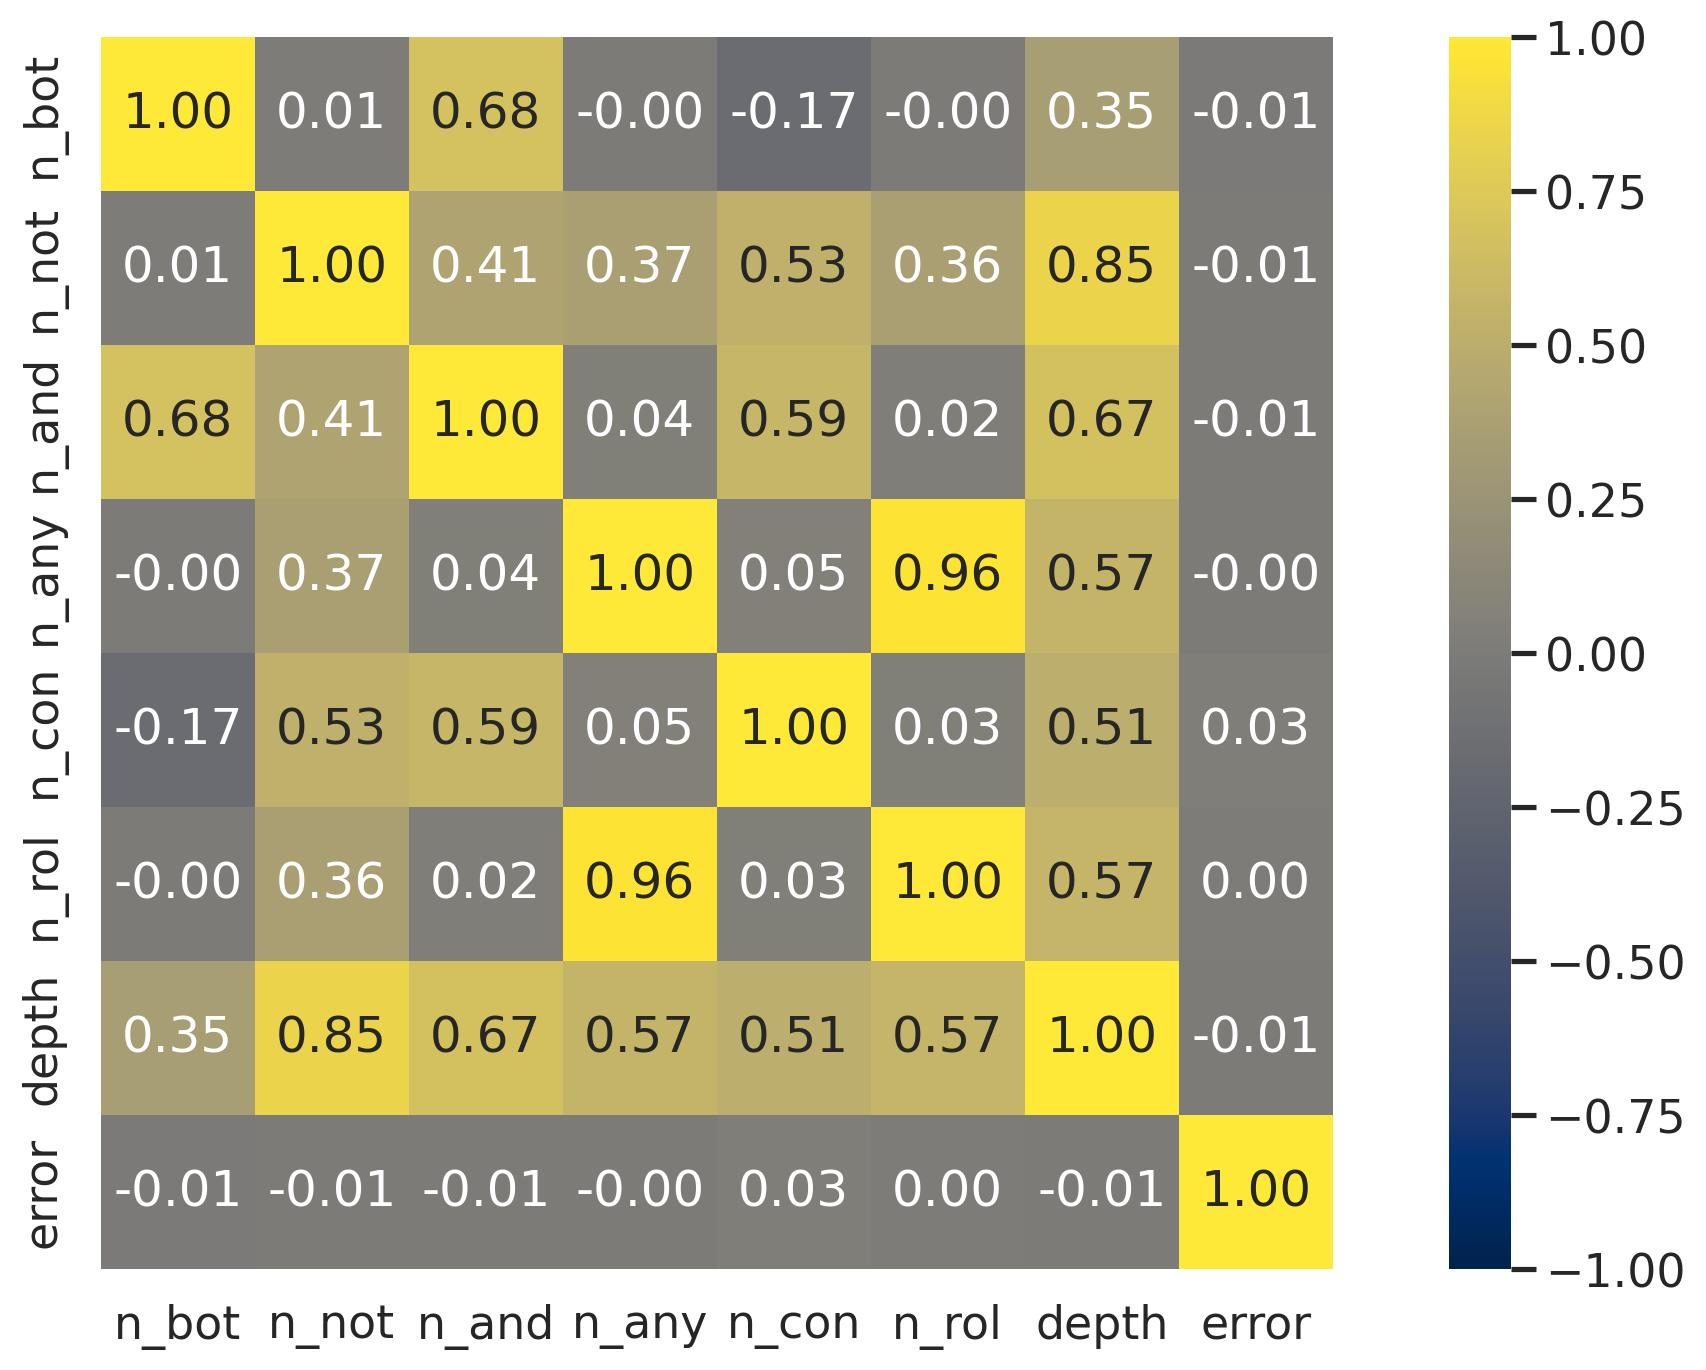

In [4]:
sns.heatmap(stats_df.corr(), annot=True, fmt='.2f', square=True, cmap='cividis', vmin=-1, vmax=1)

In [5]:
corr = pd.DataFrame()
corr['corr'] = stats_df.corr().round(4)['error']
corr = corr[corr.index != 'error']
corr.T

,n_bot,n_not,n_and,n_any,n_con,n_rol,depth
corr,-0.0106,-0.0051,-0.0062,-0.0015,0.0282,0.0004,-0.0065
